In [79]:
import math
import torch
import torch.nn as nn
device = torch.device('cuda:0')

class RangeDataset(torch.utils.data.Dataset):
  def __init__(self, start, end, step=1):
    self.start = start
    self.end = end
    self.step = step

  def __len__(self):
    return math.ceil((self.end - self.start) / self.step)
#ne pas confondre ceiling(toit) et floor(sol)   

  def __getitem__(self, index):
    value = self.start + index * self.step
    assert value < self.end
    return value

In [80]:
dataset = RangeDataset(0, 10, 2)
print(len(dataset))

5


In [81]:
dataset = RangeDataset(0,9)
data_loader = torch.utils.data.DataLoader(
dataset,
batch_size=9, #by default batch_size is 1
shuffle=True, #to have the data reshuffled at every epoch
drop_last=True    
)

for i,batch in enumerate(data_loader):
    print(i,batch)

0 tensor([6, 7, 0, 5, 4, 8, 2, 1, 3])


In [82]:
dataset_iter = iter(dataset)
print(next(dataset_iter))
print(next(dataset_iter))
print(next(dataset_iter))
print(next(dataset_iter))

0
1
2
3


In [83]:
%matplotlib inline

In [84]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [85]:
transform = transforms.Compose(
             [transforms.ToTensor(),
             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                        download=True,transform=transform)  

trainloader = torch.utils.data.DataLoader(trainset,batch_size=30,num_workers=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=30,num_workers=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                                          

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [86]:
%pwd
%ls -l
%ls -l ./data
%ls -l ./data/cifar-10-batches-py/

total 8
drwxr-xr-x 3 root root 4096 Jan 18 12:50 data/
drwxr-xr-x 1 root root 4096 Jan 13 14:34 sample_data/
total 166512
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-py/
-rw-r--r-- 1 root root 170498071 Jan 18 12:50 cifar-10-python.tar.gz
total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [87]:
def imshow(img):
    a = img/2 + 0.5
    npimg = a.numpy()
    plt.imshow(np.transpose(a,(1,2,0)))
    plt.show()

We show below 10 images of the dataset and then print the associated class

torch.Size([30, 3, 32, 32])


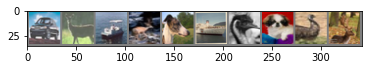

In [88]:
dataiter = iter(trainloader)
images,labels = next(dataiter)
print(images.shape)
imshow(torchvision.utils.make_grid(images[:10],nrow=10))


In [89]:
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

  car  deer  ship  deer   dog  ship  bird   dog  bird  deer


In [90]:
import torch.nn.functional as F

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet,self).__init__()

        self.conv1 = nn.Conv2d(3,6,5)     # 3 is the nb of input channels(RGB image),
                                          # 6 is the desired number of output channels, 5 is the kernel size
        self.max_pool = nn.MaxPool2d(2,2) # reduces (again) the image size by taking the max over 2x2 patches
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120) # to understand why we use 16*5*5 take a look at the forward below
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # we use 10 as the final number of neurons because there are 10 classes

    def forward(self,x):
        
        x = self.max_pool(F.relu(self.conv1(x)))   
        x = self.max_pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [91]:
CNet = ConvNet().to(device)

In [92]:
n_epochs=50

In [93]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNet.parameters(),lr=0.001,momentum=0.9)

In [94]:
for ep in range(n_epochs):
    for int,x in enumerate(trainloader,0):
        image,label = x
        image = image.to(device)
        label = label.to(device)
        y_pred = CNet(image)
        loss = criterion(y_pred,label)
        


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch {ep} loss {loss}')    


epoch 0 loss 2.1257851123809814
epoch 1 loss 1.576432704925537
epoch 2 loss 1.3189332485198975
epoch 3 loss 1.4112789630889893
epoch 4 loss 1.1378744840621948
epoch 5 loss 1.1495403051376343
epoch 6 loss 1.5470020771026611
epoch 7 loss 1.0441465377807617
epoch 8 loss 0.9454008340835571
epoch 9 loss 0.7779728174209595
epoch 10 loss 1.729257583618164
epoch 11 loss 1.0304460525512695
epoch 12 loss 1.112605094909668
epoch 13 loss 0.7269333004951477
epoch 14 loss 1.0185996294021606
epoch 15 loss 0.7279646396636963
epoch 16 loss 0.8086742162704468
epoch 17 loss 1.2158716917037964
epoch 18 loss 0.6407434940338135
epoch 19 loss 0.8842428922653198
epoch 20 loss 0.4136219918727875
epoch 21 loss 1.2482163906097412
epoch 22 loss 0.8083066940307617
epoch 23 loss 0.8673924207687378
epoch 24 loss 0.37565580010414124
epoch 25 loss 0.7515599727630615
epoch 26 loss 0.49682578444480896
epoch 27 loss 1.019935965538025
epoch 28 loss 0.22253413498401642
epoch 29 loss 0.8996604681015015
epoch 30 loss 0.61478

In [95]:
correct = 0
total = 0
with torch.no_grad():

    for i,batch in enumerate(testloader):
        images,label = batch
        images,label = images.to(device),label.to(device)
        prediction = CNet(images)  #recall that prediction is a tensor of shape B x N_Classes
        maximum,pred_indices = torch.max(prediction,dim=1)
        c = (pred_indices == label)
        correct += c.sum().item()
        total += label.size(0)
    print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))    


            
            

        

        

Accuracy of the network on the 10000 test images: 63 %
